In [1]:
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, SpatialDropout1D



## 데이터 불러오기
* 14만 개 데이터 셋

In [2]:
# CSV 파일 불러오기

data = pd.read_csv('full_Hotel_reviews.csv',  encoding='latin-1')
data = data[['rating_review','review_full']]
data.drop_duplicates(inplace=True)


In [6]:
print(len(data))

135828


# 데이터 전처리
* 특수문자 제거
* 토큰화
* 불용어 제거 및 표제어 추출
* 이상치 제거

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


# 텍스트 데이터 전처리
lemmatizer = WordNetLemmatizer()
stopwords = set(nltk.corpus.stopwords.words('english'))

def preprocess_text(text):

    # 특수 문자 제거
    text = re.sub(r"[^a-zA-Z]+", " ", str(text))
    # 소문자로 변환
    text = text.lower()
    # 단어 토큰화
    words = word_tokenize(text)

    # 불용어 제거 및 표제어 추출
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords]

    # 리스트를 공백을 포함한 문자열로 변환
    processed_text = ' '.join(words)

    return processed_text

# 텍스트 정제 및 불용어 제거
data['review_full'] = data['review_full'].apply(preprocess_text)


# Count the length of each text
text_lengths = data['review_full'].apply(lambda x: len(x.split()))

# Calculate the IQR
Q1 = text_lengths.quantile(0.25)
Q3 = text_lengths.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outlier removal
lower_bound = max(0, Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
data = data[(text_lengths >= lower_bound) & (text_lengths <= upper_bound)]


reviews = data['review_full']
labels = data['rating_review']




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JORON\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Top word list 를 추출하여 제거하기 위한 프로세스

*최빈 데이터 제거, 2만개 데이터에서 추출한 단어 리스트 ( 20개) 사용

In [ ]:
## 2만개 데이터 셋에서 추출한 top word list
        
top_word_list = ['food', 'good', 'place', 'service', 'restaurant', 'great', 'one', 'staff', 'time', 'nice', 'indian', 'delhi', 'visit', 'taste', 'best', 'also', 'dish', 'really', 'chicken']

In [ ]:

## 데이터 셋에 top word list 단어 제거 후 다시 저장
data['review_full'] = data['review_full'].apply(lambda x: ' '.join(word for word in x.split() if word not in top_word_list))


## 시퀀스 생성 및 패딩

In [18]:

reviews = data['review_full']
labels = data['rating_review']


tokenizer = Tokenizer()
tokenizer.fit_on_texts(reviews)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(reviews)
# 시퀀스의 최대 길이 계산
max_sequence_length = max([len(seq) for seq in sequences])

# 패딩 적용
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)


# 레이블 데이터 정규화
normalized_labels = (labels - labels.min()) / (labels.max() - labels.min())

train_padded = padded_sequences[::2]
train_normalized_label = normalized_labels[::2]
test_padded = padded_sequences[1::2]
test_normalized_label = normalized_labels[1::2]
test_label = labels[1::2]




88


## 모델 생성 및 훈련

In [13]:
# LSTM 모델 구축
embedding_dim = 100
vocab_size = len(word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64))
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 88, 100)           2212100   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 88, 100)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,254,405
Trainable params: 2,254,405
Non-trainable params: 0
_________________________________________________________________
None


In [6]:
# 모델 훈련
history = model.fit(train_padded, train_normalized_label, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
231/231 [==============================] - 11s 38ms/step - loss: 0.0714 - val_loss: 0.0388
Epoch 2/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0251 - val_loss: 0.0408
Epoch 3/10
231/231 [==============================] - 9s 38ms/step - loss: 0.0152 - val_loss: 0.0415
Epoch 4/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0101 - val_loss: 0.0448
Epoch 5/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0077 - val_loss: 0.0479
Epoch 6/10
231/231 [==============================] - 8s 36ms/step - loss: 0.0064 - val_loss: 0.0497
Epoch 7/10
231/231 [==============================] - 8s 36ms/step - loss: 0.0054 - val_loss: 0.0496
Epoch 8/10
231/231 [==============================] - 9s 38ms/step - loss: 0.0043 - val_loss: 0.0496
Epoch 9/10
231/231 [==============================] - 9s 37ms/step - loss: 0.0036 - val_loss: 0.0501
Epoch 10/10
231/231 [==============================] - 9s 39ms/step - loss: 0.0031 - val_l

'\nEpoch 1/10\n231/231 [==============================] - 11s 40ms/step - loss: 0.0681 - val_loss: 0.0408\nEpoch 2/10\n231/231 [==============================] - 9s 38ms/step - loss: 0.0252 - val_loss: 0.0487\nEpoch 3/10\n231/231 [==============================] - 9s 38ms/step - loss: 0.0157 - val_loss: 0.0431\nEpoch 4/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0110 - val_loss: 0.0478\nEpoch 5/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0081 - val_loss: 0.0476\nEpoch 6/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0064 - val_loss: 0.0493\nEpoch 7/10\n231/231 [==============================] - 9s 40ms/step - loss: 0.0053 - val_loss: 0.0522\nEpoch 8/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0043 - val_loss: 0.0506\nEpoch 9/10\n231/231 [==============================] - 9s 39ms/step - loss: 0.0035 - val_loss: 0.0509\nEpoch 10/10\n231/231 [==============================] - 9s 40ms/step 

## 모델 평가
* loss & val_loss
* confusion matrix

In [7]:
# 예측 결과 출력 (정수값)
predicted_ratings = model.predict(test_padded)

def convert_data(value):
    if value < 0.2:
        return 1
    elif value < 0.4:
        return 2
    elif value < 0.6:
        return 3
    elif value < 0.8:
        return 4
    else:
        return 5
    
predicted_ratings = list(map(lambda x: convert_data(float(x)), predicted_ratings))



test_labels_list = test_label.tolist()  # Convert test_labels to a Python list
for i, rating in enumerate(predicted_ratings):
    print(f"Predicted rating for review {i+1}: {rating}")


# 모델 평가
loss = model.evaluate(test_padded, test_normalized_label)
print(f"Test Loss: {loss}")


from collections import Counter

print("예측 라벨 개수 : ", Counter(predicted_ratings))
print("실제 라벨 개수 : ", Counter(test_label))

289/289 [==============================] - 3s 9ms/step
Predicted rating for review 1: 1
Predicted rating for review 2: 5
Predicted rating for review 3: 5
Predicted rating for review 4: 4
Predicted rating for review 5: 3
Predicted rating for review 6: 3
Predicted rating for review 7: 5
Predicted rating for review 8: 4
Predicted rating for review 9: 5
Predicted rating for review 10: 5
Predicted rating for review 11: 5
Predicted rating for review 12: 4
Predicted rating for review 13: 5
Predicted rating for review 14: 4
Predicted rating for review 15: 3
Predicted rating for review 16: 4
Predicted rating for review 17: 4
Predicted rating for review 18: 4
Predicted rating for review 19: 4
Predicted rating for review 20: 5
Predicted rating for review 21: 3
Predicted rating for review 22: 1
Predicted rating for review 23: 5
Predicted rating for review 24: 2
Predicted rating for review 25: 5
Predicted rating for review 26: 5
Predicted rating for review 27: 5
Predicted rating for review 28: 5
Pr

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(test_labels_list, predicted_ratings)
precision = precision_score(test_labels_list, predicted_ratings, average='weighted')
recall = recall_score(test_labels_list, predicted_ratings, average='weighted')
f1 = f1_score(test_labels_list, predicted_ratings, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

confusion_mat = confusion_matrix(test_labels_list, predicted_ratings)
print("Confusion Matrix:")
print(confusion_mat)

Accuracy: 0.5184944137108146
Precision: 0.5041089262701061
Recall: 0.5184944137108146
F1 Score: 0.5049608759082563
Confusion Matrix:
[[ 166  153  122   68   23]
 [  82  149  180  119   37]
 [  83  309  626  619  348]
 [   6   54  315  816 1135]
 [   4   16  141  625 3023]]


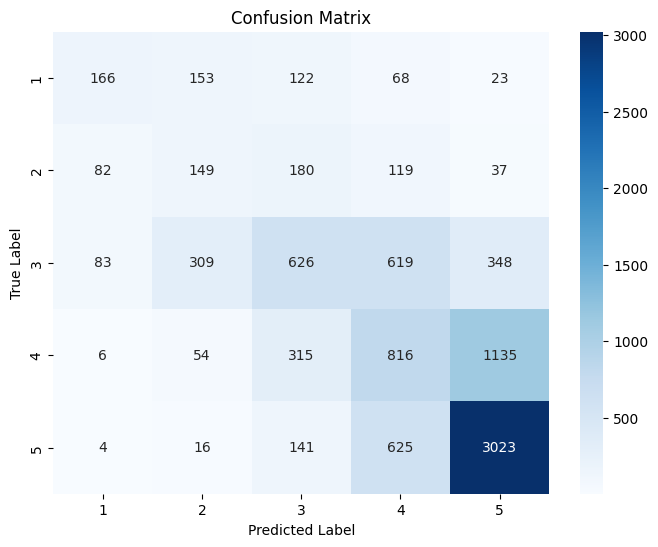

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_mat = confusion_matrix(test_labels_list, predicted_ratings)

# 클래스 라벨 설정 (1부터 5까지의 클래스)
class_labels = [1, 2, 3, 4, 5]

# 혼동 행렬을 데이터프레임으로 변환
confusion_df = pd.DataFrame(confusion_mat, index=class_labels, columns=class_labels)

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

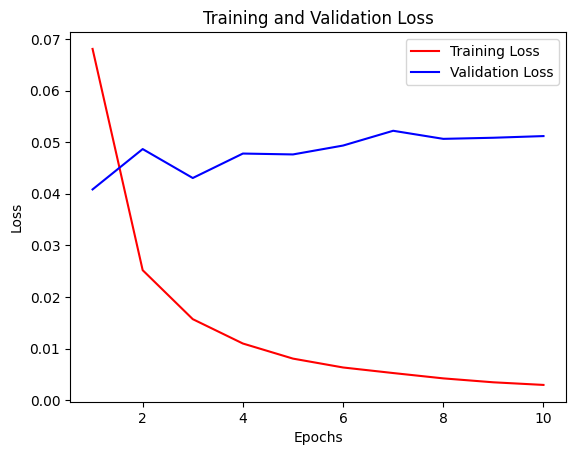

In [10]:
import matplotlib.pyplot as plt

# 훈련 손실과 검증 손실 값 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# epoch 수 추출
epochs = range(1, len(train_loss) + 1)

# 손실 값 시각화
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
